In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cartopy
import xarray as xa

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)
data = xa.open_dataarray('/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip')
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time

sub_id:  1
39 21.363590636973544
sub_id:  2
38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


In [3]:
def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, "D") == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, "h"))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, "h"))
        i += j
    return start, end

# Sub7

In [4]:
tutt_induced = np.load('../ERA5/PAU/7_TUTT_induced_flag.npy')
tc_induced = np.load('../ERA5/PAU/7_tc_corrected_flag.npy')
print(tc_induced.astype(bool)&tutt_induced.astype(bool))
print(np.where(tc_induced.astype(bool)&tutt_induced.astype(bool)))

[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
(array([ 6, 40, 86]),)


In [5]:
start, end = start_end_time(7)
print(start[6], end[6])

1981-07-08T12:00:00.000000000 1981-07-10T12:00:00.000000000


In [6]:
tc_record = xa.open_dataset('/tempest/duan0000/exprecip/ERA5/sub_IBTrack.nc')
num_TCs = len(tc_record.storm)
print('NUM_TCs: ', num_TCs)

NUM_TCs:  1581


In [7]:
def distance_criteria(xs, ys, lons, lats):  # return distance.
    dis = 12345
    for x, y in zip(xs, ys):
        if x > 180: x = x - 360
        for lon, lat in zip(lons, lats):
            if lon > 180: lon = lon - 360
            distance = np.sqrt(np.square(x - lon) + np.square(y - lat))
            if distance <= 5:
                return True
            if dis > distance:
                dis = distance
    return dis

In [8]:
lons_sub = np.load('../ERA5/Calculations/' + str(7) + '_lons.npy')
lats_sub = np.load('../ERA5/Calculations/' + str(7) + '_lats.npy')

In [9]:
class TUTT:
    def __init__(self, num_points):
        self.num_points = num_points
        self.lons = []
        self.lats = []
        self.time = []

    def add_track(self, lon, lat, dtime):
        self.lons.append(lon)
        self.lats.append(lat)
        self.time.append(dtime)
def tutt_PAU(file):
    total_record = []
    with open(file, "r") as tracks:
        total_N = -1
        lons = []
        lats = []
        times = []
        for line in tracks:
            items = line.split("\t")
            if items[0] == "start":
                if total_N >= 0:
                    tutt = TUTT(num_points=0)
                    tutt.add_track(lons, lats, times)
                    total_record.append(tutt)
                    lons = []
                    lats = []
                    times = []
                else:
                    total_N += 1
                    lons = []
                    lats = []
                    times = []
                    continue
            else:
                lon = float(items[3])
                if lon > 0:
                    lon = lon - 360
                lons.append(lon)
                lats.append(float(items[4]))
                year = items[5]
                month = items[6].zfill(2)
                date = items[7].zfill(2)
                hour = items[8].split("\n")[0].zfill(2)
                time_string = year + "-" + month + "-" + date + "T" + hour
                time = np.datetime64(time_string)
                times.append(time)
    tutt = TUTT(num_points=0)
    tutt.add_track(lons, lats, times)
    total_record.append(tutt)
    return total_record, total_N
tutts, total_N = tutt_PAU('/tempest/duan0000/exprecip/ERA5_TUTT_tracks_PV2e-6_noTC.txt')

## number 6

In [10]:
end_time = end[6]
start_time = start[6]
print(start_time, end_time)
for i in range(num_TCs):
    tc = tc_record.isel(storm=i)
    tc_time = tc.time.dropna(dim='date_time').data
    tc_start = tc_time[0]
    tc_end = tc_time[-1]
    if tc_start > end_time:
        break
    if tc_end < start_time:
        continue
    common_start = np.max([start_time, tc_start])
    common_end = np.min([end_time, tc_end])
    diffstart = (tc_time - common_start) / np.timedelta64(1, 'h')
    diffend = (tc_time - common_end) / np.timedelta64(1, 'h')
    # tc_slice = tc.sel(date_time=slice(common_start, common_end))
    start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()  # keep the positive and find the min
    end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()  # keep the negative and find the max.
    tc_lat = tc.lat.isel(date_time=slice(start_ind, end_ind + 1)).data
    tc_lon = tc.lon.isel(date_time=slice(start_ind, end_ind + 1)).data
    dis_flag = distance_criteria(xs=tc_lon, ys=tc_lat, lons=lons_sub, lats=lats_sub)
    if dis_flag == True:
        total_flag = True
        print(set(tc.usa_status.isel(date_time=slice(start_ind, end_ind+1)).data))
        print(common_start, common_end)
        tc_lat_plot = tc_lat
        tc_lon_plot = tc_lon

1981-07-08T12:00:00.000000000 1981-07-10T12:00:00.000000000
{b'TS', b'TD'}
1981-07-08T12:00:00.000000000 1981-07-09T00:00:00.000040448


In [11]:
end_time = end[6]
start_time = start[6]
print(start_time, end_time)
for i in range(len(tutts)):
    tutt = tutts[i]
    tutt_time = tutt.time[0]
    tutt_start = tutt_time[0]
    tutt_end = tutt_time[-1]
    if tutt_start > end_time:
        break
    if tutt_end < start_time:
        continue
    common_start = np.max([start_time, tutt_start])
    common_end = np.min([end_time, tutt_end])
    diffstart = (tutt_time - common_start) / np.timedelta64(1, 'h')
    diffend = (tutt_time - common_end) / np.timedelta64(1, 'h')
    start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()  # keep the positive and find the min
    end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()  # keep the negative and find the max.
    tutt_lat = tutt.lats[0][start_ind: end_ind + 1]
    tutt_lon = tutt.lons[0][start_ind: end_ind + 1]
    dis_flag = distance_criteria(xs=tutt_lon, ys=tutt_lat, lons=lons_sub, lats=lats_sub)
    if dis_flag == True:
        # total_flag = True
        print(start_ind, end_ind, 'START, END', dis_flag)
        print(common_start, common_end)
        tutt_lon_plot = tutt_lon
        tutt_lat_plot = tutt_lat

1981-07-08T12:00:00.000000000 1981-07-10T12:00:00.000000000
0 6 START, END True
1981-07-09T00:00:00.000000000 1981-07-10T12:00:00.000000000


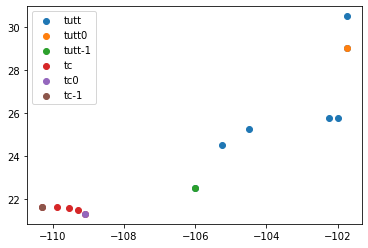

In [12]:
plt.scatter(tutt_lon_plot, tutt_lat_plot, label='tutt')
plt.scatter(tutt_lon_plot[0], tutt_lat_plot[0], label='tutt0')
plt.scatter(tutt_lon_plot[-1], tutt_lat_plot[-1], label='tutt-1')
plt.scatter(tc_lon_plot, tc_lat_plot, label='tc')
plt.scatter(tc_lon_plot[0], tc_lat_plot[0], label='tc0')
plt.scatter(tc_lon_plot[-1], tc_lat_plot[-1], label='tc-1')
plt.legend()
plt.show()

## number 40

In [13]:
end_time = end[40]
start_time = start[40]
print(start_time, end_time)
for i in range(num_TCs):
    tc = tc_record.isel(storm=i)
    tc_time = tc.time.dropna(dim='date_time').data
    tc_start = tc_time[0]
    tc_end = tc_time[-1]
    if tc_start > end_time:
        break
    if tc_end < start_time:
        continue
    common_start = np.max([start_time, tc_start])
    common_end = np.min([end_time, tc_end])
    diffstart = (tc_time - common_start) / np.timedelta64(1, 'h')
    diffend = (tc_time - common_end) / np.timedelta64(1, 'h')
    # tc_slice = tc.sel(date_time=slice(common_start, common_end))
    start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()  # keep the positive and find the min
    end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()  # keep the negative and find the max.
    tc_lat = tc.lat.isel(date_time=slice(start_ind, end_ind + 1)).data
    tc_lon = tc.lon.isel(date_time=slice(start_ind, end_ind + 1)).data
    dis_flag = distance_criteria(xs=tc_lon, ys=tc_lat, lons=lons_sub, lats=lats_sub)
    if dis_flag == True:
        total_flag = True
        print(set(tc.usa_status.isel(date_time=slice(start_ind, end_ind+1)).data))
        print(common_start, common_end)
        tc_lat_plot = tc_lat
        tc_lon_plot = tc_lon

1987-07-25T12:00:00.000000000 1987-07-26T12:00:00.000000000
{b'HU', b'TS', b'TD'}
1987-07-25T12:00:00.000000000 1987-07-26T12:00:00.000000000


In [14]:
end_time = end[40]
start_time = start[40]
print(start_time, end_time)
for i in range(len(tutts)):
    tutt = tutts[i]
    tutt_time = tutt.time[0]
    tutt_start = tutt_time[0]
    tutt_end = tutt_time[-1]
    if tutt_start > end_time:
        break
    if tutt_end < start_time:
        continue
    common_start = np.max([start_time, tutt_start])
    common_end = np.min([end_time, tutt_end])
    diffstart = (tutt_time - common_start) / np.timedelta64(1, 'h')
    diffend = (tutt_time - common_end) / np.timedelta64(1, 'h')
    start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()  # keep the positive and find the min
    end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()  # keep the negative and find the max.
    tutt_lat = tutt.lats[0][start_ind: end_ind + 1]
    tutt_lon = tutt.lons[0][start_ind: end_ind + 1]
    dis_flag = distance_criteria(xs=tutt_lon, ys=tutt_lat, lons=lons_sub, lats=lats_sub)
    if dis_flag == True:
        # total_flag = True
        print(start_ind, end_ind, 'START, END', dis_flag)
        print(common_start, common_end)
        tutt_lon_plot = tutt_lon
        tutt_lat_plot = tutt_lat

1987-07-25T12:00:00.000000000 1987-07-26T12:00:00.000000000
6 10 START, END True
1987-07-25T12:00:00.000000000 1987-07-26T12:00:00.000000000


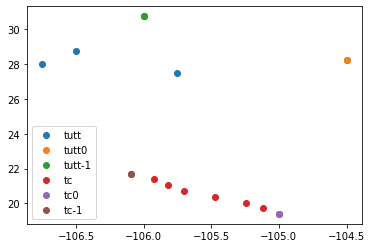

In [15]:
plt.scatter(tutt_lon_plot, tutt_lat_plot, label='tutt')
plt.scatter(tutt_lon_plot[0], tutt_lat_plot[0], label='tutt0')
plt.scatter(tutt_lon_plot[-1], tutt_lat_plot[-1], label='tutt-1')
plt.scatter(tc_lon_plot, tc_lat_plot, label='tc')
plt.scatter(tc_lon_plot[0], tc_lat_plot[0], label='tc0')
plt.scatter(tc_lon_plot[-1], tc_lat_plot[-1], label='tc-1')
plt.legend()
plt.show()

## Number 86

In [16]:
end_time = end[86]
start_time = start[86]
print(start_time, end_time)
for i in range(num_TCs):
    tc = tc_record.isel(storm=i)
    tc_time = tc.time.dropna(dim='date_time').data
    tc_start = tc_time[0]
    tc_end = tc_time[-1]
    if tc_start > end_time:
        break
    if tc_end < start_time:
        continue
    common_start = np.max([start_time, tc_start])
    common_end = np.min([end_time, tc_end])
    diffstart = (tc_time - common_start) / np.timedelta64(1, 'h')
    diffend = (tc_time - common_end) / np.timedelta64(1, 'h')
    # tc_slice = tc.sel(date_time=slice(common_start, common_end))
    start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()  # keep the positive and find the min
    end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()  # keep the negative and find the max.
    tc_lat = tc.lat.isel(date_time=slice(start_ind, end_ind + 1)).data
    tc_lon = tc.lon.isel(date_time=slice(start_ind, end_ind + 1)).data
    dis_flag = distance_criteria(xs=tc_lon, ys=tc_lat, lons=lons_sub, lats=lats_sub)
    if dis_flag == True:
        total_flag = True
        print(set(tc.usa_status.isel(date_time=slice(start_ind, end_ind+1)).data))
        print(common_start, common_end)
        tc_lat_plot = tc_lat
        tc_lon_plot = tc_lon

2003-08-22T12:00:00.000000000 2003-08-23T12:00:00.000000000
{b'TS', b'TD'}
2003-08-22T12:00:00.000040448 2003-08-23T12:00:00.000000000


In [17]:
end_time = end[86]
start_time = start[86]
print(start_time, end_time)
for i in range(len(tutts)):
    tutt = tutts[i]
    tutt_time = tutt.time[0]
    tutt_start = tutt_time[0]
    tutt_end = tutt_time[-1]
    if tutt_start > end_time:
        break
    if tutt_end < start_time:
        continue
    common_start = np.max([start_time, tutt_start])
    common_end = np.min([end_time, tutt_end])
    diffstart = (tutt_time - common_start) / np.timedelta64(1, 'h')
    diffend = (tutt_time - common_end) / np.timedelta64(1, 'h')
    start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()  # keep the positive and find the min
    end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()  # keep the negative and find the max.
    tutt_lat = tutt.lats[0][start_ind: end_ind + 1]
    tutt_lon = tutt.lons[0][start_ind: end_ind + 1]
    dis_flag = distance_criteria(xs=tutt_lon, ys=tutt_lat, lons=lons_sub, lats=lats_sub)
    if dis_flag == True:
        # total_flag = True
        print(start_ind, end_ind, 'START, END', dis_flag)
        print(common_start, common_end)
        tutt_lon_plot = tutt_lon
        tutt_lat_plot = tutt_lat

2003-08-22T12:00:00.000000000 2003-08-23T12:00:00.000000000
12 16 START, END True
2003-08-22T12:00:00.000000000 2003-08-23T12:00:00.000000000


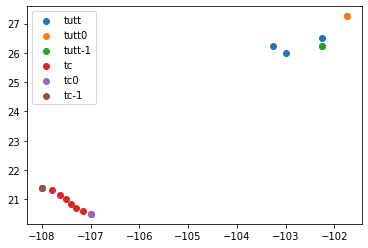

In [18]:
plt.scatter(tutt_lon_plot, tutt_lat_plot, label='tutt')
plt.scatter(tutt_lon_plot[0], tutt_lat_plot[0], label='tutt0')
plt.scatter(tutt_lon_plot[-1], tutt_lat_plot[-1], label='tutt-1')
plt.scatter(tc_lon_plot, tc_lat_plot, label='tc')
plt.scatter(tc_lon_plot[0], tc_lat_plot[0], label='tc0')
plt.scatter(tc_lon_plot[-1], tc_lat_plot[-1], label='tc-1')
plt.legend()
plt.show()

# all precip composites

In [6]:
sub_id = 7
tutt_sub = np.load(str(sub_id)+'_all_TUTT-5degree.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')

In [7]:
print(np.where((tutt_sub>0)&(tc_sub>0)))

(array([ 173,  368,  457,  622,  623,  679, 1147, 1213, 1361, 1488, 1670,
       1870, 1871, 1872, 1873, 2066, 2229, 2256, 2287, 2587, 2719, 2720,
       2733, 3002]),)


In [8]:
sub_precip = monsoon_precip.sel(sub_id=sub_id)
sub_precip = sub_precip[sub_precip>1]

In [9]:
tc_tutt_days = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])
tc_tutt_days.time.data

array(['1981-07-09T00:00:00.000000000', '1983-09-04T00:00:00.000000000',
       '1984-08-18T00:00:00.000000000', '1986-08-17T00:00:00.000000000',
       '1986-08-18T00:00:00.000000000', '1987-07-26T00:00:00.000000000',
       '1993-08-22T00:00:00.000000000', '1994-08-13T00:00:00.000000000',
       '1996-08-24T00:00:00.000000000', '1998-07-19T00:00:00.000000000',
       '2000-09-17T00:00:00.000000000', '2003-08-23T00:00:00.000000000',
       '2003-08-24T00:00:00.000000000', '2003-08-25T00:00:00.000000000',
       '2003-08-26T00:00:00.000000000', '2006-07-26T00:00:00.000000000',
       '2008-07-25T00:00:00.000000000', '2008-08-24T00:00:00.000000000',
       '2009-06-24T00:00:00.000000000', '2013-07-09T00:00:00.000000000',
       '2014-09-14T00:00:00.000000000', '2014-09-15T00:00:00.000000000',
       '2015-06-18T00:00:00.000000000', '2018-08-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [10]:
import scipy.stats
from matplotlib import colors
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import matplotlib as mpl
def plot_composites(sub_id, field, time, fig, ax, title, rolling=None, vmax=None, confidence=False):
    field_sel = field.sel(time=time)
    mean = field_sel.mean(dim='time')
    std = field_sel.std(dim='time')
    if confidence:
        t_statistic = mean/(std/np.sqrt(mean.shape[0]))
        t_flatten = t_statistic.data.reshape(-1)
        crit1 = scipy.stats.norm.ppf(1-0.05/2)
        ind = np.where((t_flatten>-crit1)&(t_flatten<crit1))[0]
        plot_mean = mean.data.copy()
        plot_mean_flatten = plot_mean.reshape(-1)
        plot_mean_flatten[ind]=np.nan
        plot_mean = plot_mean_flatten.reshape(t_statistic.shape)
    else:
        plot_mean = mean.data.copy()
    if vmax is None:
        vmin = np.nanmin(plot_mean)
        vmax = np.nanmax(plot_mean)
        vmax = np.max([np.abs(vmin), vmax])
    norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    ax.contourf(mean.longitude, mean.latitude, plot_mean, levels=50, norm=norm, cmap='coolwarm')
    if confidence:
        if rolling is None:
            ax.contour(mean.longitude, mean.latitude, t_statistic, levels=[-crit1, crit1], colors='black')
        else:
            t_smooth = t_statistic.rolling(latitude=10, center=True).mean().dropna("latitude")
            t_smooth = t_smooth.rolling(longitude=10, center=True).mean().dropna("longitude")
            ax.contour(t_smooth.longitude, t_smooth.latitude, t_smooth, levels=[-crit1, crit1], colors='black')
    # ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
    ax.set_title(title)
    
    fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(sub_id)+".shp"
    shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
    ax.add_feature(shape_feature)

In [11]:
slp_anomaly = xa.open_dataarray('../Composites/daily_slp_stand_anomaly.nc')
z500_anomaly = xa.open_dataarray('../Composites/daily_z500_stand_anomaly.nc')
ivt_a_anomaly = xa.open_dataarray('../Composites/daily_ivt_a_stand_anomaly.nc')
ivt_b_anomaly = xa.open_dataarray('../Composites/daily_ivt_b_stand_anomaly.nc')
tcwv_anomaly = xa.open_dataarray('../Composites/daily_tcwv_stand_anomaly.nc')
pv200_anomaly = xa.open_dataarray('../Composites/daily_pv200_stand_anomaly.nc')
q850_anomaly = xa.open_dataarray('../Composites/daily_q850_stand_anomaly.nc')

w500_anomaly = xa.open_dataarray('../Composites/daily_w500_std_anomaly.nc')
cape_anomaly = xa.open_dataarray('../Composites/daily_cape_std_anomaly.nc')

## TC+TUTT

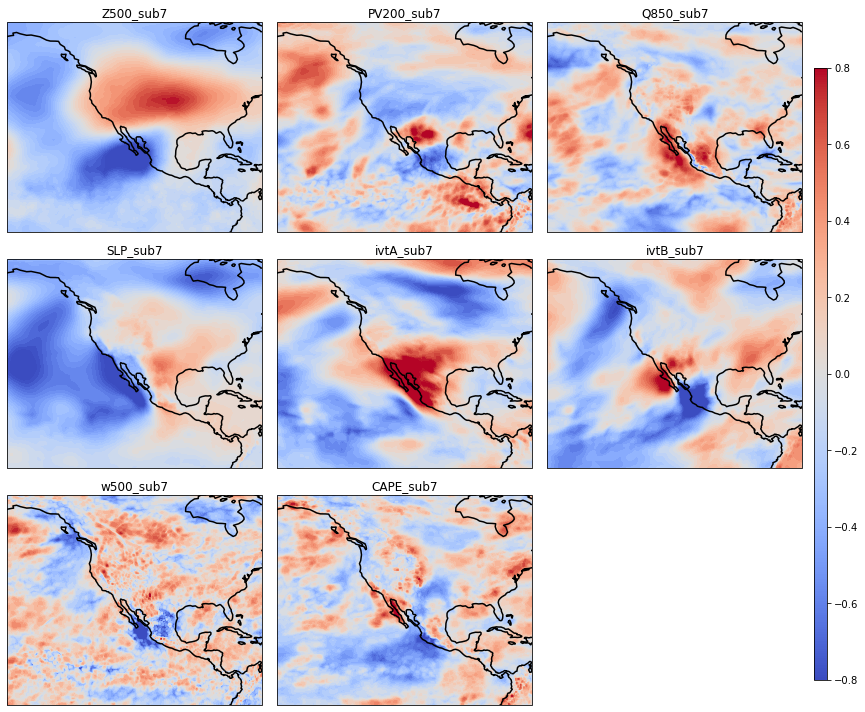

In [12]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(331, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=z500_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='Z500_sub7', vmax=0.8)
# add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(332, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=pv200_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='PV200_sub7', vmax=0.8)
# add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(333, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=q850_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='Q850_sub7', vmax=0.8)
# add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(334, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=slp_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='SLP_sub7', vmax=0.8)
ax = fig.add_subplot(335, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_a_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='ivtA_sub7', vmax=0.8)
ax = fig.add_subplot(336, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_b_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='ivtB_sub7', vmax=0.8)
ax = fig.add_subplot(337, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=w500_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='w500_sub7', vmax=0.8)
ax = fig.add_subplot(338, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=cape_anomaly, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='CAPE_sub7', vmax=0.8)

# add_latlon(ax, top=False, left=False, bottom=True, right=False)
vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## TC_Only

In [13]:
tc_notutt_days = sub_precip.isel(time=np.where((tutt_sub==0)&(tc_sub>0))[0])
tc_days = sub_precip.isel(time=np.where((tc_sub>0))[0])
# tc_notutt_days.time.data

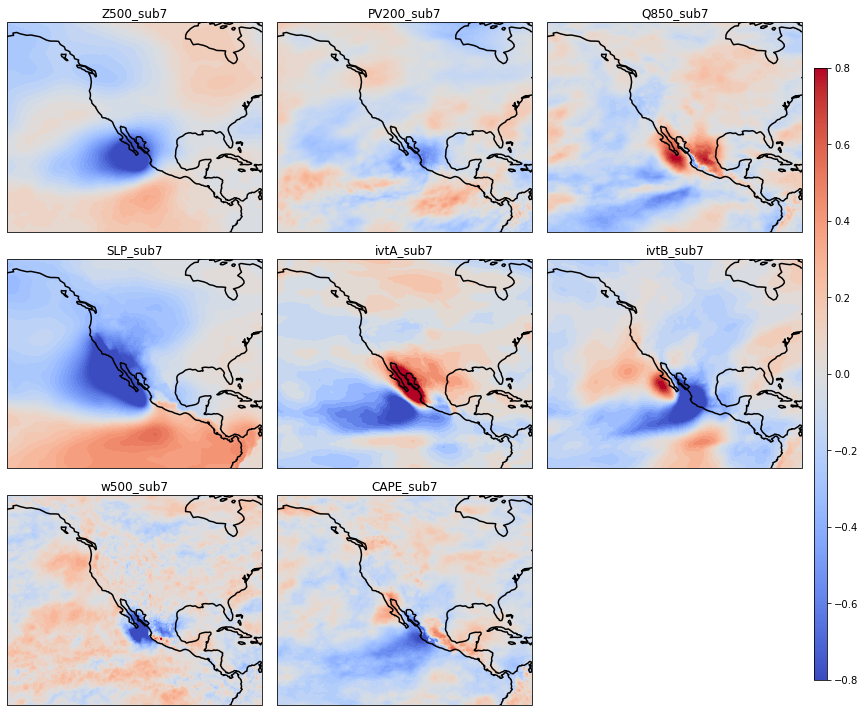

In [14]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(331, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=z500_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='Z500_sub7', vmax=0.8)
# add_latlon(ax, top=True, left=True, bottom=False, right=False)
ax = fig.add_subplot(332, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=pv200_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='PV200_sub7', vmax=0.8)
# add_latlon(ax, top=True, left=False, bottom=False, right=False)
ax = fig.add_subplot(333, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=q850_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='Q850_sub7', vmax=0.8)
# add_latlon(ax, top=False, left=True, bottom=True, right=False)
ax = fig.add_subplot(334, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=slp_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='SLP_sub7', vmax=0.8)
# add_latlon(ax, top=False, left=False, bottom=True, right=False)
ax = fig.add_subplot(335, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_a_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='ivtA_sub7', vmax=0.8)
ax = fig.add_subplot(336, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_b_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='ivtB_sub7', vmax=0.8)
ax = fig.add_subplot(337, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=w500_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='w500_sub7', vmax=0.8)
ax = fig.add_subplot(338, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=cape_anomaly, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='CAPE_sub7', vmax=0.8)

vmax = 0.8
norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
plt.tight_layout()
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)

plt.show()

## actual values

In [15]:
tcwv = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/tcwv_all.nc')
tcwv = tcwv.resample(time='1D').first()
w500 = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/1979-2018_w500_all.nc')
w500 = w500.resample(time='1D').first()
ivt_a = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/data/N2N_Monsoon/ivt_a_1979_2019')
ivt_a = ivt_a.sel(longitude=slice(-150, -71)).sel(latitude=slice(64, -1))
ivt_a = ivt_a.resample(time='1D').first()
ivt_b = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/data/N2N_Monsoon/ivt_b_1979_2019')
ivt_b = ivt_b.sel(longitude=slice(-150, -71)).sel(latitude=slice(64, -1))
ivt_b = ivt_b.resample(time='1D').first()

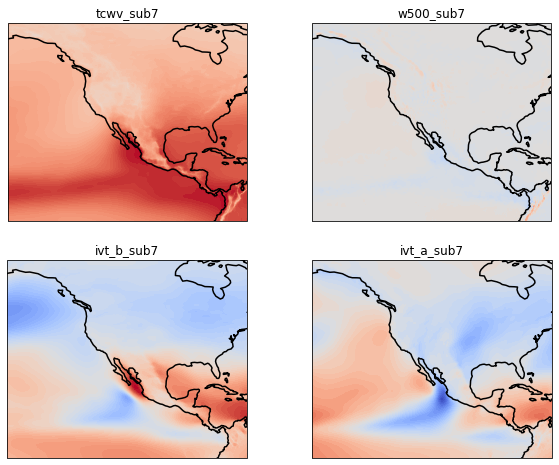

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=tcwv, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='tcwv_sub7', vmax=None)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=w500, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='w500_sub7', vmax=None)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_a, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='ivt_b_sub7', vmax=None)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_b, time=tc_notutt_days.time.data, fig=fig, ax=ax, title='ivt_a_sub7', vmax=None)

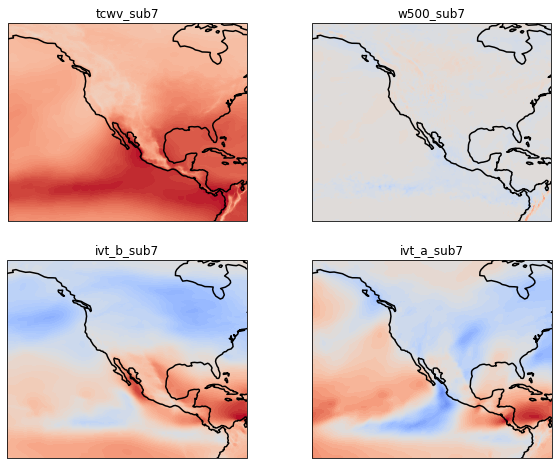

In [17]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(221, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=tcwv, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='tcwv_sub7', vmax=None)
ax = fig.add_subplot(222, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=w500, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='w500_sub7', vmax=None)
ax = fig.add_subplot(223, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_a, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='ivt_b_sub7', vmax=None)
ax = fig.add_subplot(224, projection=cartopy.crs.PlateCarree())
plot_composites(sub_id=7, field=ivt_b, time=tc_tutt_days.time.data, fig=fig, ax=ax, title='ivt_a_sub7', vmax=None)

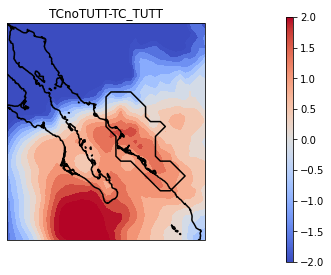

In [19]:
tc_tutt_tcwv = tcwv.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_cwv = tcwv.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
con = ax.contourf(tc_tutt_tcwv.longitude, tc_tutt_tcwv.latitude, tc_notutt_cwv-tc_tutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
ax.set_title('TCnoTUTT-TC_TUTT')
plt.show()

In [20]:
print(np.min(tc_notutt_cwv-tc_tutt_tcwv))
print(np.max(tc_notutt_cwv-tc_tutt_tcwv))

<xarray.DataArray 'TCWV' ()>
array(-7.3712025, dtype=float32)
<xarray.DataArray 'TCWV' ()>
array(4.225239, dtype=float32)


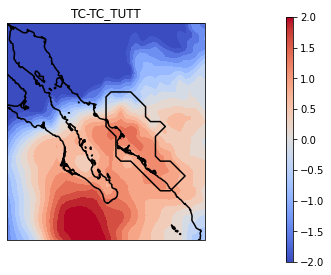

In [21]:
tc_tutt_tcwv = tcwv.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_cwv = tcwv.sel(time=tc_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
con = ax.contourf(tc_tutt_tcwv.longitude, tc_tutt_tcwv.latitude, tc_notutt_cwv-tc_tutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-TC_TUTT')
plt.show()

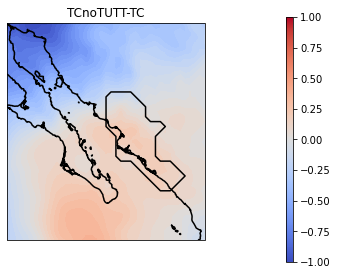

In [22]:
tc_tutt_tcwv = tcwv.sel(time=tc_days.time.data).mean(dim='time')
tc_notutt_cwv = tcwv.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure()
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_tutt_tcwv.longitude, tc_tutt_tcwv.latitude, tc_notutt_cwv-tc_tutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
ax.set_title('TCnoTUTT-TC')
plt.show()

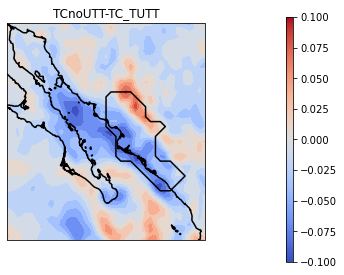

In [23]:
tc_tutt_w500 = w500.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_w500 = w500.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)
con = ax.contourf(tc_tutt_tcwv.longitude, tc_tutt_tcwv.latitude, tc_notutt_w500-tc_tutt_w500, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
ax.set_title('TCnoUTT-TC_TUTT')
plt.show()

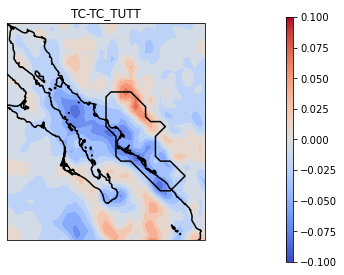

In [24]:
tc_tutt_w500 = w500.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_w500 = w500.sel(time=tc_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)
con = ax.contourf(tc_tutt_tcwv.longitude, tc_tutt_tcwv.latitude, tc_notutt_w500-tc_tutt_w500, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-TC_TUTT')
plt.show()

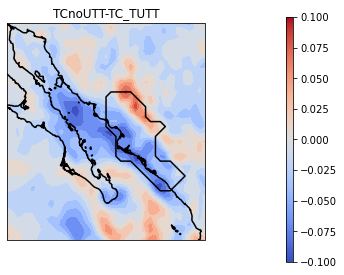

In [25]:
tc_tutt_w500 = w500.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_w500 = w500.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-0.1, vcenter=0, vmax=0.1)
con = ax.contourf(tc_tutt_tcwv.longitude, tc_tutt_tcwv.latitude, tc_notutt_w500-tc_tutt_w500, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
ax.set_title('TCnoUTT-TC_TUTT')
plt.show()

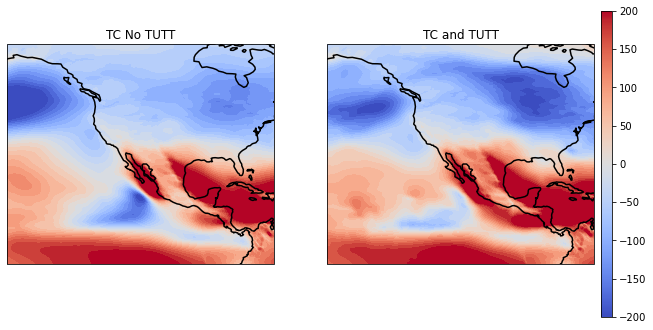

In [26]:
tc_tutt_ivtA = ivt_a.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtA = ivt_a.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.set_title('TC No TUTT')
norm = colors.TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200)
con = ax.contourf(tc_tutt_ivtA.longitude, tc_tutt_ivtA.latitude, tc_notutt_ivtA, cmap='coolwarm', norm=norm, levels=60)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.set_title('TC and TUTT')
con = ax.contourf(tc_tutt_ivtA.longitude, tc_tutt_ivtA.latitude, tc_tutt_ivtA, cmap='coolwarm', norm=norm, levels=60)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
# ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
plt.show()

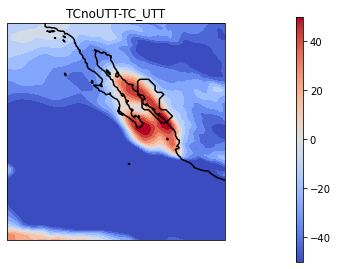

In [27]:
tc_tutt_ivtA = ivt_a.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtA = ivt_a.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, tc_notutt_ivtA-tc_tutt_ivtA, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCnoUTT-TC_UTT')
plt.show()

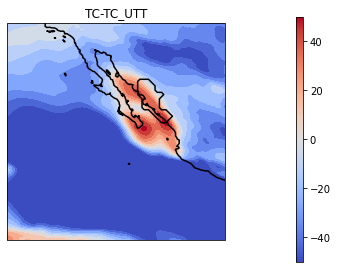

In [28]:
tc_tutt_ivtA = ivt_a.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtA = ivt_a.sel(time=tc_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, tc_notutt_ivtA-tc_tutt_ivtA, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-TC_UTT')
plt.show()

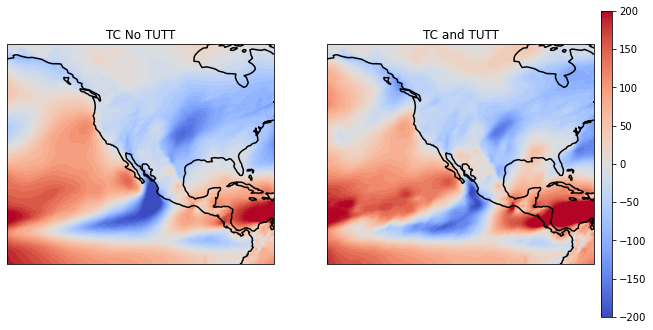

In [29]:
tc_tutt_ivtB = ivt_b.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtB = ivt_b.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
ax.set_title('TC No TUTT')
norm = colors.TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200)
con = ax.contourf(tc_tutt_ivtA.longitude, tc_tutt_ivtA.latitude, tc_notutt_ivtB, cmap='coolwarm', norm=norm, levels=60)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
ax.set_title('TC and TUTT')
con = ax.contourf(tc_tutt_ivtA.longitude, tc_tutt_ivtA.latitude, tc_tutt_ivtB, cmap='coolwarm', norm=norm, levels=60)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
# ax.set_extent([245, 255, 21, 32], crs=cartopy.crs.PlateCarree())
plt.show()

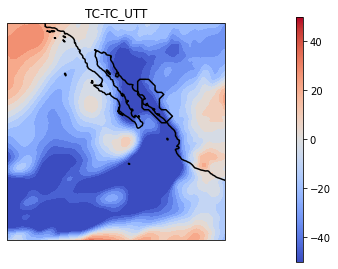

In [39]:
tc_tutt_ivtB = ivt_b.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtB = ivt_b.sel(time=tc_notutt_days.time.data).mean(dim='time')
tc_ivtB = ivt_b.sel(time=tc_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, tc_ivtB-tc_tutt_ivtB, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-TC_UTT')
plt.show()

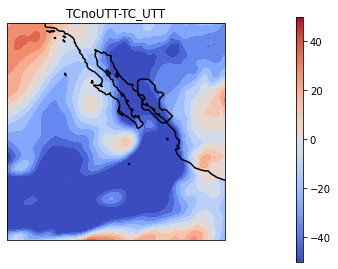

In [31]:
tc_tutt_ivtB = ivt_b.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtB = ivt_b.sel(time=tc_notutt_days.time.data).mean(dim='time')
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, tc_notutt_ivtB-tc_tutt_ivtB, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
vmax = 0.8
fig.subplots_adjust(right=0.94)
cbar_ax = fig.add_axes([0.95, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCnoUTT-TC_UTT')
plt.show()

In [32]:
print(np.max(tc_tutt_ivtA))
print(np.min(tc_tutt_ivtA))

<xarray.DataArray ()>
array(434.5472, dtype=float32)
<xarray.DataArray ()>
array(-223.65703, dtype=float32)


In [88]:
sub_id = 7
tutt_sub = np.load(str(sub_id)+'_all_TUTT-5degree.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')

In [89]:
tc_tutt_days = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])
tc_notutt_days = sub_precip.isel(time=np.where((tutt_sub==0)&(tc_sub>0))[0])
tc_days = sub_precip.isel(time=np.where((tc_sub>0))[0])
print(len(tc_days))
print(len(tc_tutt_days))
print(len(tc_notutt_days))

178
24
154


/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


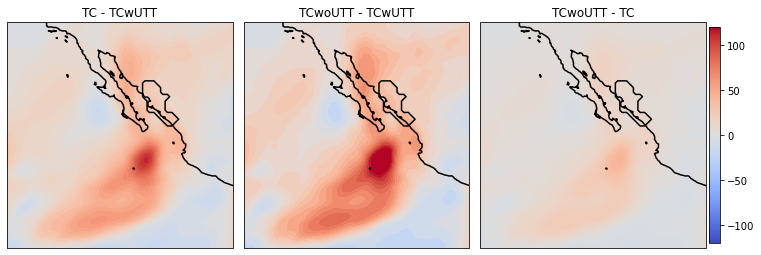

In [77]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-120, vcenter=0, vmax=120)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_ivtB-(-tc_tutt_ivtB), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC - TCwUTT', fontsize=12)
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_notutt_ivtB-(-tc_tutt_ivtB), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT - TCwUTT', fontsize=12)
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_notutt_ivtB-(-tc_ivtB), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT - TC', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.99, 0.25, 0.015, 0.5])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

# 10 degree

In [110]:
sub_id = 7
tutt_sub = np.load(str(sub_id)+'_all_TUTT-10degree.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')

In [111]:
print(np.where((tutt_sub>0)&(tc_sub>0)))

(array([ 173,  314,  368,  415,  416,  417,  418,  420,  457,  622,  623,
        679,  770,  817, 1142, 1147, 1151, 1213, 1304, 1361, 1487, 1488,
       1527, 1531, 1651, 1652, 1670, 1870, 1871, 1872, 1873, 2031, 2066,
       2067, 2185, 2188, 2211, 2212, 2229, 2256, 2287, 2453, 2586, 2587,
       2719, 2720, 2733, 2858, 2882, 3002]),)


In [112]:
tc_tutt_days = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])
tc_notutt_days = sub_precip.isel(time=np.where((tutt_sub==0)&(tc_sub>0))[0])
tc_days = sub_precip.isel(time=np.where((tc_sub>0))[0])

In [113]:
tc_ivtB = ivt_b.sel(time=tc_days.time.data).mean(dim='time')
tc_tutt_ivtB = ivt_b.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_ivtB = ivt_b.sel(time=tc_notutt_days.time.data).mean(dim='time')
tc_tcwv = tcwv.sel(time=tc_days.time.data).mean(dim='time')
tc_tutt_tcwv = tcwv.sel(time=tc_tutt_days.time.data).mean(dim='time')
tc_notutt_tcwv = tcwv.sel(time=tc_notutt_days.time.data).mean(dim='time')

In [114]:
print(len(tc_days))
print(len(tc_tutt_days))
print(len(tc_notutt_days))

178
50
128


/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


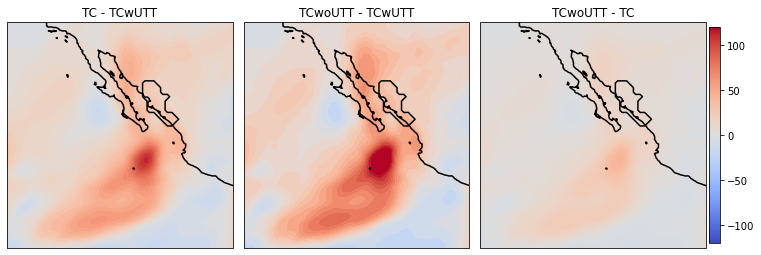

In [115]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-120, vcenter=0, vmax=120)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_ivtB-(-tc_tutt_ivtB), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC - TCwUTT', fontsize=12)
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_notutt_ivtB-(-tc_tutt_ivtB), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT - TCwUTT', fontsize=12)
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_notutt_ivtB-(-tc_ivtB), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT - TC', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.99, 0.25, 0.015, 0.5])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


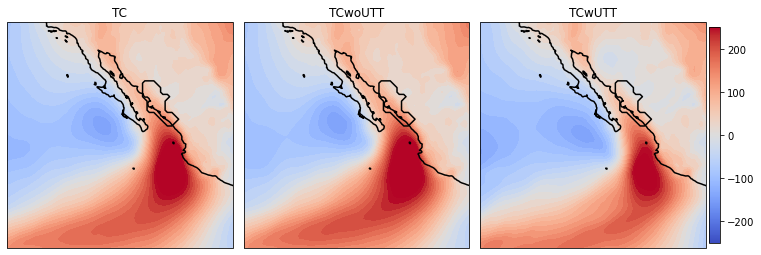

In [116]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-250, vcenter=0, vmax=250)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_ivtB, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC', fontsize=12)
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_notutt_ivtB, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT', fontsize=12)
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_tutt_ivtB, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwUTT', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.99, 0.25, 0.015, 0.5])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

## TCWV

/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


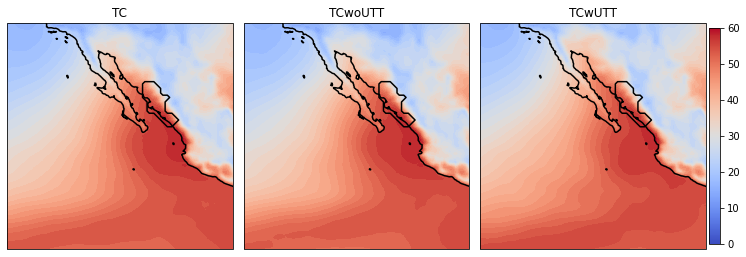

In [122]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
norm = colors.Normalize(vmin=0, vmax=60)
con = ax.contourf(tc_tcwv.longitude, tc_tcwv.latitude, tc_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC', fontsize=12)
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_tcwv.longitude, tc_tcwv.latitude, tc_notutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT', fontsize=12)
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_tcwv.longitude, tc_tcwv.latitude, tc_tutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwUTT', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.99, 0.25, 0.015, 0.5])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


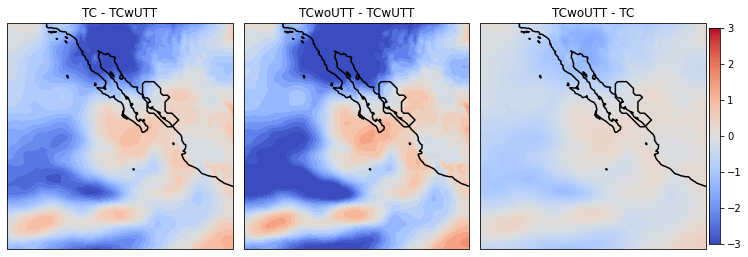

In [126]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3)
con = ax.contourf(tc_tcwv.longitude, tc_tcwv.latitude, tc_tcwv-tc_tutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC - TCwUTT', fontsize=12)
ax = fig.add_subplot(132, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_tcwv.longitude, tc_tcwv.latitude, tc_notutt_tcwv-tc_tutt_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT - TCwUTT', fontsize=12)
ax = fig.add_subplot(133, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_tcwv.longitude, tc_tcwv.latitude, tc_notutt_tcwv-tc_tcwv, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TCwoUTT - TC', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.99, 0.25, 0.015, 0.5])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

# 10 vs 5

In [90]:
sub_id = 7
tutt_sub = np.load(str(sub_id)+'_all_TUTT-10degree.npy')
tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
tc_tutt_days_10 = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])
tutt_sub = np.load(str(sub_id)+'_all_TUTT-5degree.npy')
tc_tutt_days_5 = sub_precip.isel(time=np.where((tutt_sub>0)&(tc_sub>0))[0])

In [91]:
tc_tutt_ivtB_10 = ivt_b.sel(time=tc_tutt_days_10.time.data).mean(dim='time')
tc_tutt_ivtB_5 = ivt_b.sel(time=tc_tutt_days_5.time.data).mean(dim='time')

/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


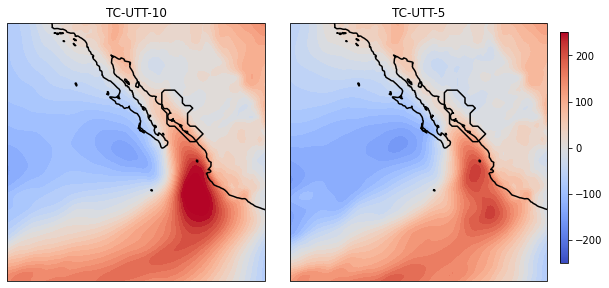

In [102]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-250, vcenter=0, vmax=250)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_tutt_ivtB_10, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-UTT-10', fontsize=12)
ax = fig.add_subplot(122, projection=cartopy.crs.PlateCarree())
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_tutt_ivtB_5, cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-UTT-5', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.99, 0.1, 0.015, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


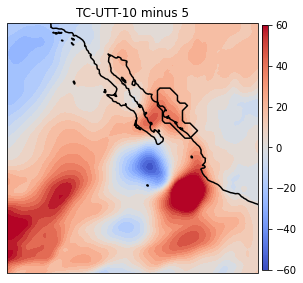

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=cartopy.crs.PlateCarree())
norm = colors.TwoSlopeNorm(vmin=-60, vcenter=0, vmax=60)
con = ax.contourf(tc_notutt_ivtA.longitude, tc_notutt_ivtA.latitude, -tc_tutt_ivtB_10-(-tc_tutt_ivtB_5), cmap='coolwarm', norm=norm, levels=40)
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1.5)
fname = "/tempest/duan0000/exprecip/cpc-global/NAM_SUB_SHAPES/NAM-mask-"+str(7)+".shp"
shape_feature = ShapelyFeature(Reader(fname).geometries(), cartopy.crs.PlateCarree(), facecolor="none", linewidth=1.5)
ax.add_feature(shape_feature)
ax.set_extent([235, 260, 10, 35], crs=cartopy.crs.PlateCarree())
ax.set_title('TC-UTT-10 minus 5', fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.8, 0.05, 0.015, 0.85])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="coolwarm"), cax=cbar_ax)
plt.tight_layout()
plt.show()

* 10 degree and 5 degree both depress IVT-B. 5 degree is stronger. 

# Precip Composites

In [ ]:
sub_id = 7
precip = monsoon_precip.sel(sub_id=sub_id)
precip_data = precip.data
precip_time = precip.where(precip > 1, drop=True).time.data
print(len(precip_time))

In [ ]:
from tqdm import tqdm
def start_end_time(sub_id):  # for all precipitation events.
    start = []
    end = []
    ext_times = precip_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        start.append(ext_times[i] - np.timedelta64(12, 'h'))
        end.append(ext_times[i] + np.timedelta64(12, 'h'))  # 12Z to 12Z
        i += 1
    return start, end
precip_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    precip_time = precip.where(precip > 1, drop=True).time.data
    print(len(precip_time))
    precip_days[sub_id] = precip_time

def TC_precip_loc(sub_id, sub_lons, sub_lats):
    tc_lats = []
    tc_lons = []
    start, end = start_end_time(sub_id)
    tc_induced_flag = np.zeros(len(start))
    ind_tc = 0
    for ind, (time1, time2) in enumerate(tqdm(zip(start, end))):  # time is 12Z.
        total_flag = 0
        start_time = time1
        end_time = time2
        # print(start_time, end_time)
        for i in range(np.maximum(ind_tc-5, 0), num_TCs):
            ind_tc = i
            tc = tc_record.isel(storm=i)
            tc_time = tc.time.dropna(dim='date_time').data
            tc_start = tc_time[0]
            tc_end = tc_time[-1]
            if tc_start > end_time:
                break
            if tc_end < start_time:
                continue
            common_start = np.max([start_time, tc_start])
            common_end = np.min([end_time, tc_end])
            diffstart = (tc_time - common_start) / np.timedelta64(1, 'h')
            diffend = (tc_time - common_end) / np.timedelta64(1, 'h')
            # keep the positive and find the min
            start_ind = np.where(diffstart >= 0, diffstart, np.inf).argmin()
            # keep the negative and find the max.
            end_ind = np.where(diffend <= 0, diffend, -np.inf).argmax()
            tc_lat = tc.lat.isel(date_time=slice(start_ind, end_ind + 1)).data
            tc_lon = tc.lon.isel(date_time=slice(start_ind, end_ind + 1)).data
            dis_flag = distance_criteria(
                xs=tc_lon, ys=tc_lat, lons=sub_lons, lats=sub_lats)
            if dis_flag == True:
                # check type
                tc_type = set(tc.usa_status.isel(date_time=slice(start_ind, end_ind+1)).data)
                if tc_type.intersection(set([b'TS', b'TY', b'ST', b'TC', b'HU', b'HR']))==set():
                    pass
                else:
                    total_flag += 1
                    ave_lat = np.mean(tc_lat)
                    ave_lon = np.mean(tc_lon)
                    tc_lats.append(ave_lat)
                    tc_lons.append(ave_lon)
        if total_flag > 0:
            tc_induced_flag[ind] = 1
            print('TC')
    return tc_induced_flag, tc_lats, tc_lons

In [ ]:
tc_induced_flag, tc_lats, tc_lons = TC_precip_loc(sub_id=7, sub_lons=lons_sub, sub_lats=lats_sub)

In [ ]:
print(np.unique(tc_induced_flag, return_counts=True))

In [ ]:
np.unique(tc_sub, return_counts=True)

In [ ]:
print(len(tc_lats))
start, end = start_end_time(sub_id)
print(len(start), ' ', len(tc_induced_flag), ' ', len(tutt_induced))
print(tc_lons)

In [ ]:
cpc_anomaly = xa.open_dataarray('/tempest/duan0000/exprecip/cpc-global/nc-data/Anomaly_cpc.nc')
cpc_anomaly.isel(time=100).plot()

In [ ]:
tc_composite = []
tc_utt_composite = []
ind = 0
for i in range(len(tc_induced_flag)):
    if tc_induced_flag[i]>0 and tutt_sub[i]==0: # only tc, no TUTT
        time = end[i]-np.timedelta64(12, 'h')
        lon = tc_lons[ind]
        lat = tc_lats[ind]
        min_lon = lon-20
        max_lon = lon+20
        min_lat = lat-20
        max_lat = lat+20
        precip_anomaly = cpc_anomaly.sel(time=time)
        precip_anomaly = precip_anomaly.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon+360, max_lon+360))
        tc_composite.append(precip_anomaly.data[:80, :80].reshape(1, 80, 80)) # time, lat, lon
        ind+=1
    if tc_induced_flag[i]>0 and tutt_sub[i]>0: # TC+TUTT:
        time = end[i]-np.timedelta64(12, 'h')
        lon = tc_lons[ind]
        lat = tc_lats[ind]
        min_lon = lon-20
        max_lon = lon+20
        min_lat = lat-20
        max_lat = lat+20
        precip_anomaly = cpc_anomaly.sel(time=time)
        precip_anomaly = precip_anomaly.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon+360, max_lon+360))
        tc_utt_composite.append(precip_anomaly.data[:80, :80].reshape(1, 80, 80)) # time, lat, lon
        ind+=1

In [ ]:
tc_anomaly_composite = np.concatenate(tc_composite)
print(tc_anomaly_composite.shape)
tc_utt_anomaly_composite = np.concatenate(tc_utt_composite)
print(tc_utt_anomaly_composite.shape)

In [ ]:
plt.imshow(tc_anomaly_composite.mean(axis=0))

In [ ]:
plt.imshow(tc_utt_anomaly_composite.mean(axis=0))

In [ ]:
trmm_precip= xa.open_dataarray('/tempest/duan0000/exprecip/TRMM_NAM.nc')
trmm_precip.isel(time=100).plot()
print(trmm_precip.time)
trmm_precip

In [ ]:
print(len(tc_induced_flag))

In [ ]:
import pandas as pd
tc_composite = []
tc_utt_composite = []
count = np.zeros((160, 160))
ind_tc = 0
for i in range(len(tc_induced_flag)):
    # print(i)
    if tc_induced_flag[i]>0: # all tc
        lon = tc_lons[ind]
        lat = tc_lats[ind]
        time = end[i]-np.timedelta64(12, 'h')
        # print(i, time)
        if pd.to_datetime(time).year>2012 or pd.to_datetime(time).year<1998:
            ind_tc+=1
            # print(pd.to_datetime(time).year)
            continue
        else:
            count[:]+=1
            min_lon = lon-20
            max_lon = lon+20
            min_lat = lat-20
            max_lat = lat+20
            precip_anomaly = trmm_precip.sel(time=time, tolerance=np.timedelta64(4, 'h'), method='nearest')
            precip_anomaly = precip_anomaly.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon+360, max_lon+360))
            # print(precip_anomaly.shape)
            if precip_anomaly.shape[0]<160:
                ind = precip_anomaly.shape[0]
                temp = np.zeros((160, 160))
                temp[:] = np.NAN
                temp[:precip_anomaly.shape[0]] = precip_anomaly
                precip_anomaly = temp
                count[ind:, :] = count[ind:, :]-1
            print(precip_anomaly.shape)
            tc_composite.append(precip_anomaly.data[:160, :160].reshape(1, 160, 160)) # time, lat, lon
            ind_tc+=1


In [ ]:
print(len(tc_composite))
tc_anomaly_composite_trmm = np.concatenate(tc_composite, axis=0)
plt.imshow(tc_anomaly_composite_trmm.mean(axis=0))
plt.colorbar()

In [ ]:
import pandas as pd
tc_composite = []
tc_utt_composite = []
count = np.zeros((160, 160))
ind_tc = 0
for i in range(len(tc_induced_flag)):
    # print(i)
    if tc_induced_flag[i]>0 and tutt_sub[i]>0: # tc+utt
        lon = tc_lons[ind]
        lat = tc_lats[ind]
        time = end[i]-np.timedelta64(12, 'h')
        # print(i, time)
        if pd.to_datetime(time).year>2012 or pd.to_datetime(time).year<1998:
            ind_tc+=1
            # print(pd.to_datetime(time).year)
            continue
        else:
            count[:]+=1
            min_lon = lon-20
            max_lon = lon+20
            min_lat = lat-20
            max_lat = lat+20
            precip_anomaly = trmm_precip.sel(time=time, tolerance=np.timedelta64(4, 'h'), method='nearest')
            precip_anomaly = precip_anomaly.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon+360, max_lon+360))
            # print(precip_anomaly.shape)
            if precip_anomaly.shape[0]<160:
                ind = precip_anomaly.shape[0]
                temp = np.zeros((160, 160))
                temp[:] = np.NAN
                temp[:precip_anomaly.shape[0]] = precip_anomaly
                precip_anomaly = temp
                count[ind:, :] = count[ind:, :]-1
            print(precip_anomaly.shape)
            tc_utt_composite.append(precip_anomaly.data[:160, :160].reshape(1, 160, 160)) # time, lat, lon
            ind_tc+=1


In [ ]:
tc_utt_composite_trmm = np.concatenate(tc_utt_composite, axis=0)
plt.imshow(tc_utt_composite_trmm.mean(axis=0))
plt.colorbar()

In [ ]:
import matplotlib.ticker as mticker
from matplotlib import colors, cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

plot_tc = tc_anomaly_composite_trmm.mean(axis=0)
plot_tc_utt = tc_utt_composite_trmm.mean(axis=0)
norm = colors.Normalize(vmin=0, vmax=50)
lat = np.linspace(-20, 20, 160)
lon = np.linspace(-20, 20, 160)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.contourf(lon, lat, plot_tc, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_title('TC')
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)
ax = fig.add_subplot(122)
ax.set_title('tc_utt')
ax.contourf(lon, lat, plot_tc_utt, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)

ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)

plt.show()

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
norm = colors.TwoSlopeNorm(vmin=-30, vcenter=0, vmax=30)
ax.contourf(lon, lat, plot_tc-plot_tc_utt, levels=40, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_title('TC-TC_UTT')
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)

In [ ]:
plot_tc.shape

In [ ]:
np.sum(plot_tc[80-20:80+20, 80-20:80+20]-plot_tc_utt[80-20:80+20, 80-20:80+20])

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
norm = colors.TwoSlopeNorm(vmin=-30, vcenter=0, vmax=30)
ax.contourf(lon[80-20:80+20], lat[80-20:80+20], plot_tc[80-20:80+20, 80-20:80+20]-plot_tc_utt[80-20:80+20, 80-20:80+20], levels=40, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)
ax.set_xticks([-5, -3, 0, 3, 5])
ax.set_yticks([-5, -3, 0, 3, 5])
ax.set_title('TC-TC_UTT')
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)

In [ ]:
plot_tc = tc_anomaly_composite_trmm.max(axis=0)
plot_tc_utt = tc_utt_composite_trmm.max(axis=0)
norm = colors.Normalize(vmin=0, vmax=380)
lat = np.linspace(-20, 20, 160)
lon = np.linspace(-20, 20, 160)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.contourf(lon, lat, plot_tc, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_title('TC')
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)
ax = fig.add_subplot(122)
ax.set_title('tc_utt')
ax.contourf(lon, lat, plot_tc_utt, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)

ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)

plt.show()

In [ ]:
np.mean(plot_tc[80-20:80+20, 80-20:80+20]-plot_tc_utt[80-20:80+20, 80-20:80+20])

# Storm-centered Composites

In [ ]:
u850 = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/1979-2018_u850_all.nc')
v850 = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/1979-2018_v850_all.nc')
tcwv = xa.open_dataarray('/tempest/duan0000/exprecip/ERA5/meteoData/tcwv_all.nc')

In [ ]:
u850

In [ ]:
tc_composite_u = []
tc_composite_v = []
tc_composite_tcwv = []

tc_utt_composite_u = []
tc_utt_composite_v = []
tc_utt_composite_tcwv = []
ind_tc = 0
for i in range(len(tc_induced_flag)):
    # print(i)
    if tc_induced_flag[i]>0 and tutt_sub[i]>0: # tc+utt
        lon = tc_lons[ind]
        lat = tc_lats[ind]
        time = end[i]
        # print(i, time)
        
        min_lon = lon-20
        max_lon = lon+20
        min_lat = lat-20
        max_lat = lat+20
        u = u850.sel(time=time)
        u = u.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon+360, max_lon+360))
        v = v850.sel(time=time)
        v = v.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon+360, max_lon+360))
        water = tcwv.sel(time=time)
        water = water.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon+360, max_lon+360))
        tc_utt_composite_u.append(u.data[:160, :160].reshape(1, 160, 160)) # time, lat, lon
        tc_utt_composite_v.append(v.data[:160, :160].reshape(1, 160, 160))
        tc_utt_composite_tcwv.append(water.data[:160, :160].reshape(1, 160, 160))
        ind_tc+=1
    if tc_induced_flag[i]>0 and tutt_sub[i]==0: # only tc, no TUTT
        lon = tc_lons[ind]
        lat = tc_lats[ind]
        time = end[i]
        
        min_lon = lon-20
        max_lon = lon+20
        min_lat = lat-20
        max_lat = lat+20
        u = u850.sel(time=time)
        u = u.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon+360, max_lon+360))
        v = v850.sel(time=time)
        v = v.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon+360, max_lon+360))
        water = tcwv.sel(time=time)
        water = water.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon+360, max_lon+360))
        tc_composite_u.append(u.data[:160, :160].reshape(1, 160, 160)) # time, lat, lon
        tc_composite_v.append(v.data[:160, :160].reshape(1, 160, 160))
        tc_composite_tcwv.append(water.data[:160, :160].reshape(1, 160, 160))
        ind_tc+=1

In [ ]:
lat = np.linspace(-20, 20, 160)
lon = np.linspace(-20, 20, 160)
print(lat.shape, lon.shape)
plot_u = np.mean(tc_composite_u, axis=0)[0]
plot_v = np.mean(tc_composite_v, axis=0)[0]
plot_tcwv = np.mean(tc_composite_tcwv, axis=0)[0]
print(plot_u.shape, ' ', plot_v.shape)
fig = plt.figure(figsize=(7, 7))
plt.contourf(lon, lat, plot_tcwv)
plt.quiver(lon[::15], lat[::15], plot_u[::15, ::15], plot_v[::15, ::15])
plt.colorbar()

In [ ]:
norm = colors.Normalize(vmin=0, vmax=60)
lat = np.linspace(-20, 20, 160)
lon = np.linspace(-20, 20, 160)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
plot_u = np.mean(tc_composite_u, axis=0)[0]
plot_v = np.mean(tc_composite_v, axis=0)[0]
plot_tcwv = np.mean(tc_composite_tcwv, axis=0)[0]
ax.contourf(lon, lat, plot_tcwv, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_title('TCnoUTT')
ax.barbs(lon[::10], lat[::10], plot_u[::10, ::10], plot_v[::10, ::10])
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)
ax = fig.add_subplot(122)
ax.set_title('TC+TUTT')
plot_u = np.mean(tc_utt_composite_u, axis=0)[0]
plot_v = np.mean(tc_utt_composite_v, axis=0)[0]
plot_tcwv = np.mean(tc_utt_composite_tcwv, axis=0)[0]
ax.contourf(lon, lat, plot_tcwv, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.barbs(lon[::10], lat[::10], plot_u[::10, ::10], plot_v[::10, ::10])
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)

plt.show()

In [ ]:
norm = colors.Normalize(vmin=0, vmax=5)
lat = np.linspace(-20, 20, 160)
lon = np.linspace(-20, 20, 160)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
plot_u = np.mean(tc_composite_u, axis=0)[0]
plot_v = np.mean(tc_composite_v, axis=0)[0]
plot_tcwv = np.mean(tc_composite_tcwv, axis=0)[0]
plot_uu = np.mean(tc_utt_composite_u, axis=0)[0]
plot_vv = np.mean(tc_utt_composite_v, axis=0)[0]
plot_tcwvv = np.mean(tc_utt_composite_tcwv, axis=0)[0]

ax.contourf(lon, lat, plot_tcwv-plot_tcwvv, levels=20, norm=norm, cmap='coolwarm')
ax.set_xlabel('longitude', fontsize=12)
ax.set_ylabel('latitude', fontsize=12)
ax.set_xticks([-20, -10, 0, 10, 20])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_title('TCnoUTT-TC_UTT')
ax.barbs(lon[::10], lat[::10], (plot_u-plot_uu)[::10, ::10], (plot_v-plot_vv)[::10, ::10])
gl = ax.grid(visible=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
divider = make_axes_locatable(ax)
cax1 = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes, pack_start=False)
fig.add_axes(cax1)
fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="coolwarm"),
    cax=cax1,
    orientation="vertical",
)